In [2]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [3]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=False, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [4]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 32
matfile : t150204001_probe1_contact3_unit1.mat


['P1-6-1', 'P2-24-1', 'P1-19-1', 'P1-17-1', 'P1-12-1']

In [5]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

### Format spike times 

In [6]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [7]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [354096 355172 356491 357799 359134 360433 361087]
times as neo events : [354096. 355172. 356491. 357799. 359134. 360433. 361087.] ms
spike train sample : [    334    5067    6996 ... 3658225 3659812 3660582]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [8]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


### Format target

In [9]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [10]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

In [11]:
indices = np.arange(0, completeUnit+1)
spikes_times_aligned = spikes_times_aligned[indices]
spikes_times_aligned[0,0]

{'unit_label': 'P1-6-1',
 'trial_unit': 0,
 't_start_ref': 61233,
 't_start_aligned': 0,
 't_stop_aligned': 6923,
 'spike_time': array([0]),
 'spike_train': array([0])}

# Raster plot

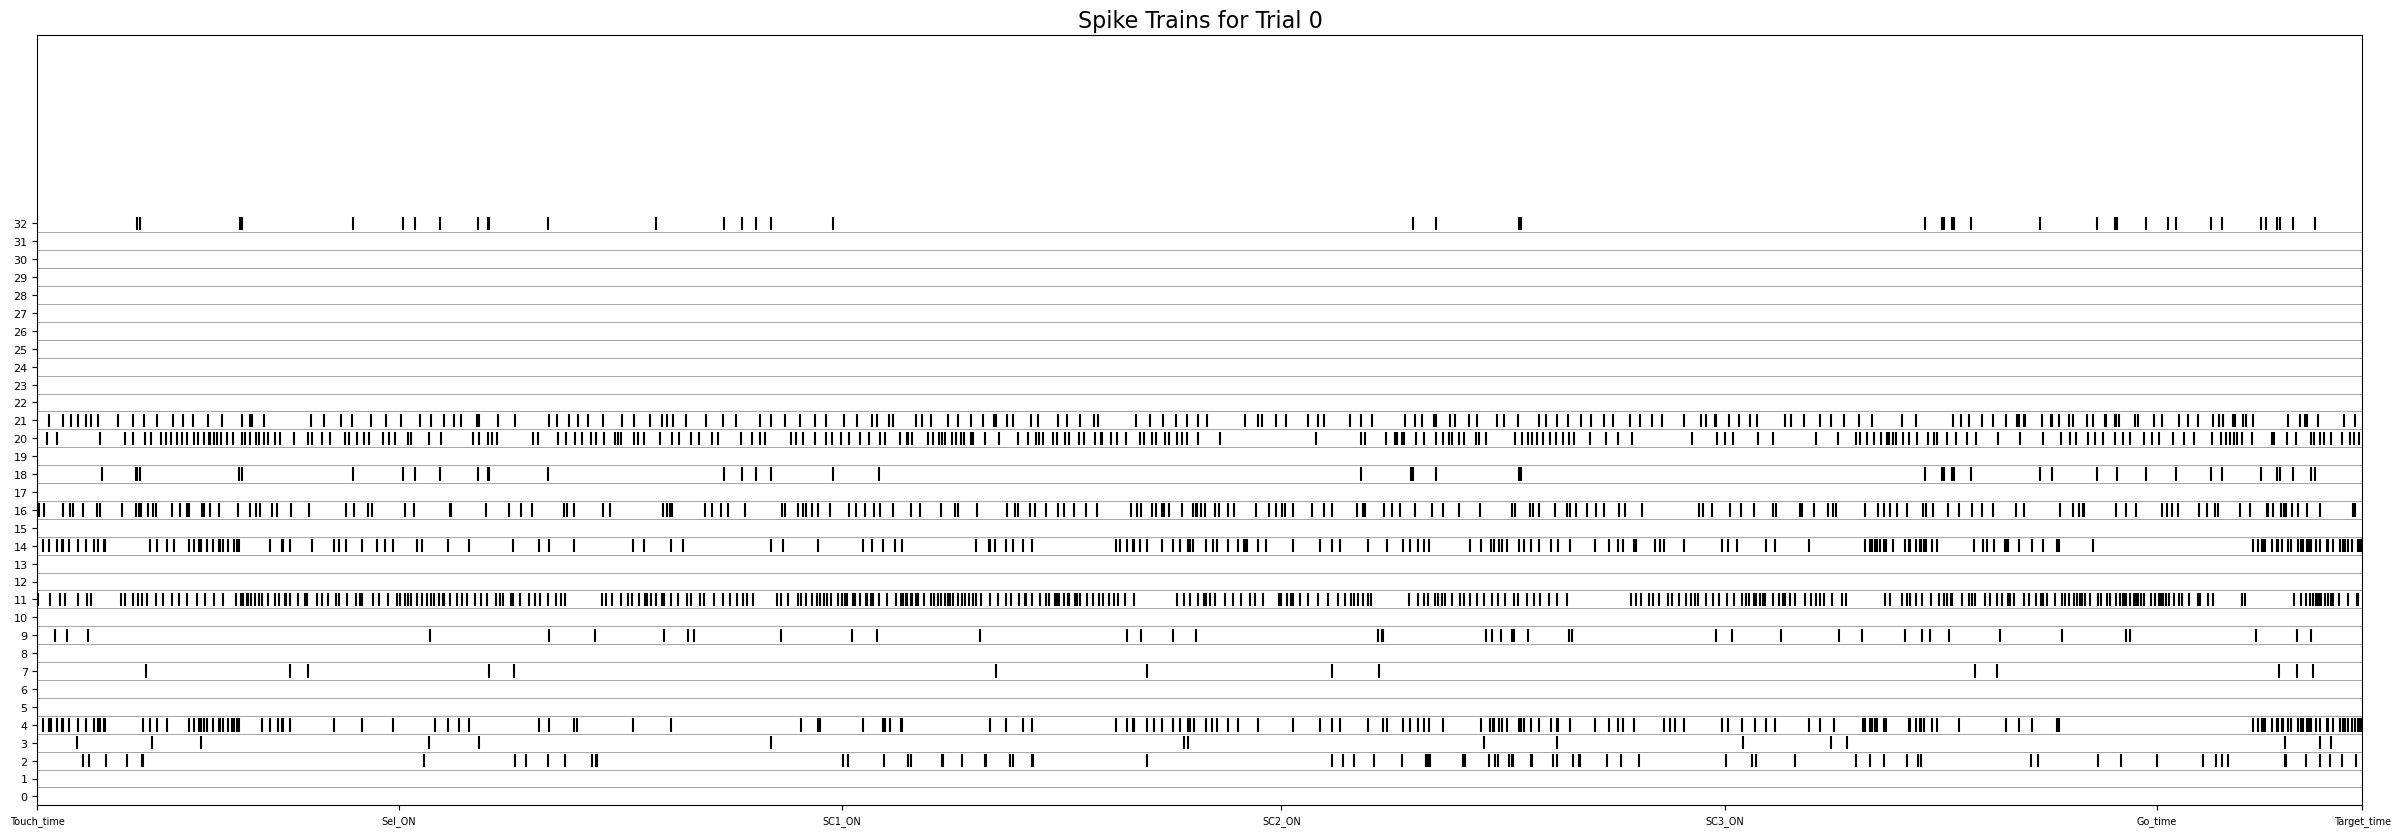

In [12]:
n_neurons = spikes_times_aligned.shape[0]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# Compute measure

## Instantaneous Firing rate 

In [13]:
sigma = [10]

max_length = tools.get_max_length_trials(spikes_times_aligned[-1])
spikes_binarized = FiringRate.binarize_spike_times(spikes_times_aligned, max_length)
spike_convolved = FiringRate.convolve_spike_binarized(spikes_binarized, sigma)

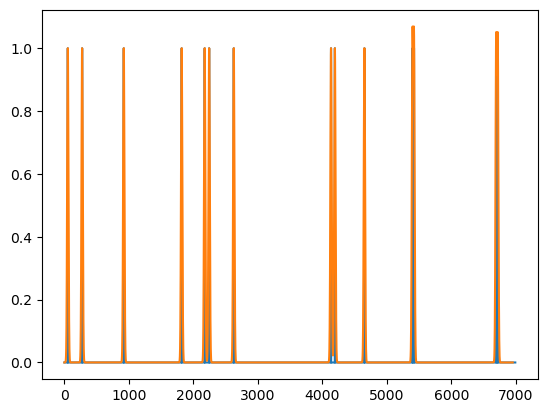

In [14]:
plt.plot(spikes_binarized[128,:,0])
plt.plot(spike_convolved[128,:,0])

## Paiwise synchrony

In [15]:
row, col = np.triu_indices(n_neurons, k=1)
n_pairs = len(row)
list_pairs = np.zeros((n_pairs,3), dtype='int')

for n_p, (r,c) in enumerate(zip(row, col)):
    list_pairs[n_p, 0] =  r
    list_pairs[n_p, 1] =  c
    list_pairs[n_p, 2] =  n_p

In [16]:
n_trials, n_times, n_neurons = spike_convolved.shape
Synch = np.zeros((n_trials, n_times, n_pairs))


for t in range(n_trials) :     
    for n_p, (r,c) in enumerate(zip(row, col)):
        Synch[t,:,n_p] = spike_convolved[t, :, r] * spike_convolved[t, :, c]

In [ ]:
row

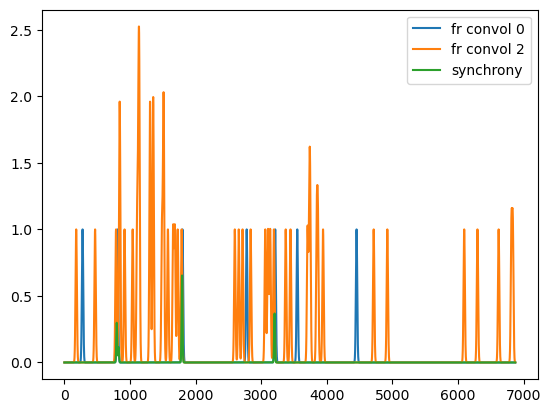

In [17]:
n0 = 0
n1 = 2
neurons_ = [n0,n1]
pair = list_pairs[np.logical_and(list_pairs[:,0] == n0, list_pairs[:,1] == n1)][0][2]
plt.plot(spike_convolved[121,:,n0], label=f'fr convol {n0}')
plt.plot(spike_convolved[121,:,n1], label=f'fr convol {n1}')
plt.plot(Synch[121,:,pair], label='synchrony')
plt.legend()

## ISI Distance

In [18]:
X_isi_ = np.zeros((n_trials), dtype=object)
ISI_distance = []
X_isi = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop_aligned']
    X_isi_one_trial = np.zeros((n_neurons, n_times))
    for n in range(n_neurons) :
        x_isi = ISI.compute(spikes_times_aligned[n][t]) 
        X_isi_one_trial[n, :] = x_isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(X_isi_one_trial[r, :], X_isi_one_trial[c, :])
    
    X_isi.append(X_isi_one_trial)
    ISI_distance.append(ISI_distance_one_trials)

In [19]:
max_length, time = tools.get_max_length_ISI(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)
X_isi_interp = np.zeros((n_trials, max_length, n_neurons), dtype=np.float32)


for t in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[t, :, p]  = ISI.interpolate_ISI_distance(ISI_distance[t][p], max_length)
        for n in range(n_neurons) : 
                X_isi_interp[t, :, n] = ISI.interpolate_X_isi(X_isi[t][n], max_length)
        

# Plot measure

7304
(176, 7304, 33)
(176, 7304, 33)


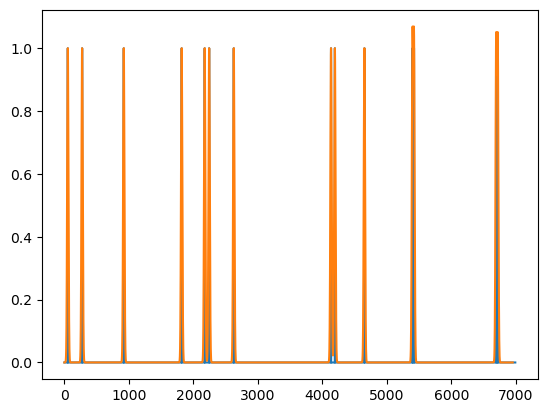

In [20]:
print(max_length)
print(spikes_binarized.shape)
print(spike_convolved.shape)
plt.plot(spikes_binarized[128,:,0])
plt.plot(spike_convolved[128,:,0])

(-500.0, 7804.0)

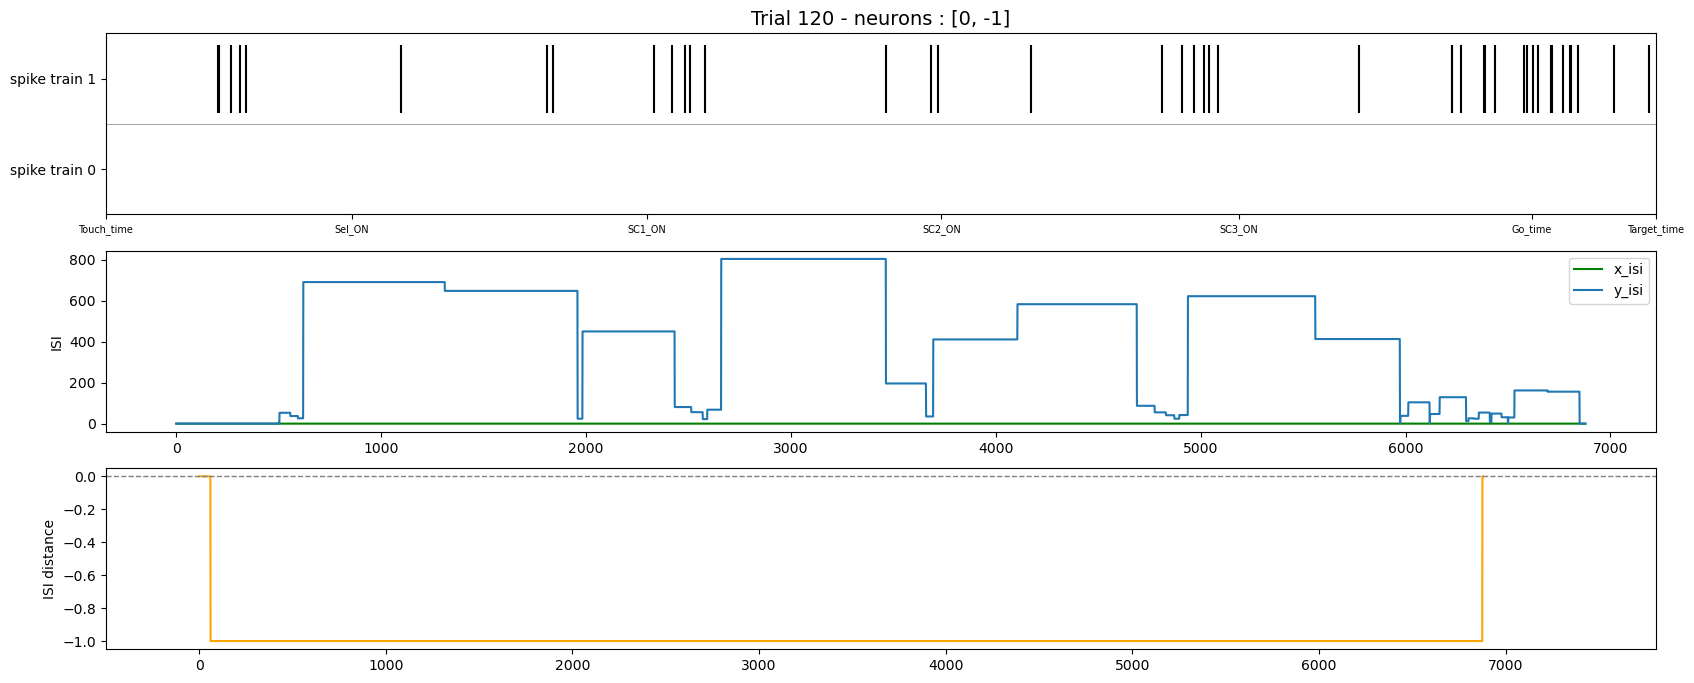

In [21]:
t = 120
neurons_ = [0,-1]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))
# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits



# Classif 

In [28]:
n_times = list(np.arange(0, ISI_distance_interp.shape[1], 500))
n_bins = len(n_times)

# Initialiser une liste vide pour stocker les moyennes de bin
list_mean = {'FR'  : [],
            'Synch' : [],
            'ISI': []}

list_data = {'FR' : spike_convolved,
            'Synch': Synch,
            'ISI': ISI_distance_interp}

# Calculer la moyenne sur l'axe des temps
for key, data in list_data.items():
    # Calculer les moyennes pour chaque bin et chaque paire
    for start, end in zip(n_times[:-1], n_times[1:]):
        # Extraire les données pour le bin actuel
        bin_data = data[:, start:end, :]
        # Calculer la moyenne sur l'axe des temps
        bin_mean = np.nanmean(bin_data, axis=1)
        # Convertir les moyennes en DataFrame et les ajouter à la liste
        bin_mean_df = pd.DataFrame(bin_mean)
        list_mean[key].append(bin_mean_df)

In [23]:
# Build pipeline
n_splits = 1
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
# Standardisation scheme
scaler = StandardScaler()
# Algo
estimator = HistGradientBoostingClassifier(max_iter=5, max_depth=10, max_bins=10)
clf = make_pipeline(scaler, estimator)

In [24]:
list_models = {'FR'  : [],
            'Synch' : [],
            'ISI': []}
for key, data in list_mean.items():
    for idx, t in enumerate(n_times[:-1]):
        model = HistGrad.Model_info(n_splits=n_splits, n_events=n_bins, \
        data=data[idx], cvs=cvs0, clf=clf)
        
        list_models[key].append(model)

In [ ]:
acc_df = HistGrad.run(list_models, target, n_times)
acc_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Séparez les données par type
test_data = acc_df[(acc_df['data_type'] == 'test') & (acc_df['target_type'] == 'trial_type')]
shuff_data = acc_df[(acc_df['data_type'] == 'shuff') & (acc_df['target_type'] == 'trial_type')]

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', hue='measure', marker='o', linestyle='-')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()

In [31]:
acc_df = HistGrad.run_by_unit(list_models, target, n_times)

#################
SPLIT : 0
##################
FR
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
Synch
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
ISI
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
#################
SPLIT : 1
##################
FR
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
Synch
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
ISI
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [32]:
result_path = '/home/laurie/Bureau/pattern_classification_git/results/'
acc_df.to_csv(result_path+'acc_df_single_unit.csv')

In [33]:
acc_df

,split,data_type,measure,time,unit/pairs,target_type,accuracy,y_true,y_pred
0,0,test,FR,0,0,trial_type,0.416667,"[1, 2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,shuff,FR,0,0,trial_type,0.305556,"[1, 2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,0,test,FR,0,0,position,0.194444,"[3, 4, 3, 2, 4, 2, 2, 4, 3, 4, 4, 3, 3, 4, 4, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
3,0,shuff,FR,0,0,position,0.361111,"[3, 4, 3, 2, 4, 2, 2, 4, 3, 4, 4, 3, 3, 4, 4, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
4,0,test,FR,0,0,type_and_pos,0.055556,"[1, 5, 4, 0, 8, 0, 3, 2, 1, 2, 5, 4, 4, 8, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...
182947,1,shuff,ISI,6500,527,trial_type,0.305556,"[1, 1, 2, 3, 2, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, ...","[1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, ..."
182948,1,test,ISI,6500,527,position,0.277778,"[2, 4, 3, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 2, 2, ...","[2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, ..."
182949,1,shuff,ISI,6500,527,position,0.333333,"[2, 4, 3, 2, 2, 2, 2, 2, 2, 4, 3, 4, 4, 2, 2, ...","[2, 2, 2, 2, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, ..."
182950,1,test,ISI,6500,527,type_and_pos,0.111111,"[0, 2, 4, 6, 3, 0, 0, 0, 6, 8, 1, 8, 2, 0, 6, ...","[2, 2, 2, 2, 8, 8, 8, 2, 8, 2, 2, 2, 2, 2, 2, ..."


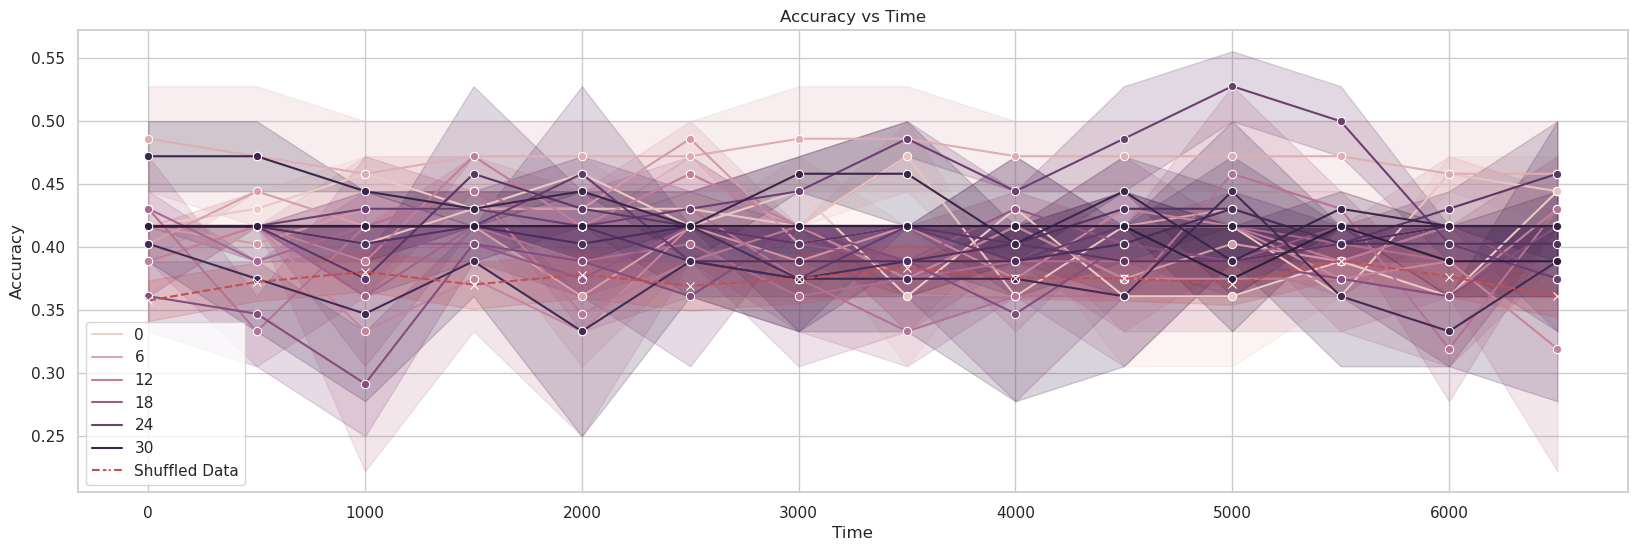

In [36]:
# Séparez les données par type

test_data = acc_df[(acc_df['data_type'] == 'test') & (acc_df['target_type'] == 'trial_type') & (acc_df['measure'] == 'FR')]
shuff_data = acc_df[(acc_df['data_type'] == 'shuff') & (acc_df['target_type'] == 'trial_type') & (acc_df['measure'] == 'FR')]

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(20, 6))

#for n_p, (r,c) in enumerate(zip(row, col)):

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', hue='unit/pairs', marker='o', linestyle='-')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()
